In [ ]:
from iohblade.loggers import ExperimentLogger
from iohblade.plots import plot_convergence, plot_experiment_CEG, plot_boxplot_fitness_hue, plot_boxplot_fitness, fitness_table
import os

logger = ExperimentLogger('paper_results/MABBOB_guided', True)
logger.add_read_dir('paper_results/MABBOB_guided_baselines')
logger.add_read_dir('paper_results/MABBOB_guided_baselines2')
log_data = logger.get_data()
log_data.head()

,method_name,problem_name,llm_name,method,problem,llm,solution,log_dir,seed
0,ES,MA_BBOB,gpt-5-mini-2025-08-07,"{'method_name': 'ES', 'budget': 200, 'kwargs':...","{'name': 'MA_BBOB', 'dims': [10], 'training_in...","{'model': 'gpt-5-mini-2025-08-07', 'code_patte...","{'id': '1075fb19-2d1a-4413-9005-a84684f12f29',...",run-ES-MA_BBOB-2,2
1,ES,MA_BBOB,gpt-5-mini-2025-08-07,"{'method_name': 'ES', 'budget': 200, 'kwargs':...","{'name': 'MA_BBOB', 'dims': [10], 'training_in...","{'model': 'gpt-5-mini-2025-08-07', 'code_patte...","{'id': '97b09f41-16dd-4b97-b046-9dcd1f56a34c',...",run-ES-MA_BBOB-1,1
2,ES,MA_BBOB,gpt-5-mini-2025-08-07,"{'method_name': 'ES', 'budget': 200, 'kwargs':...","{'name': 'MA_BBOB', 'dims': [10], 'training_in...","{'model': 'gpt-5-mini-2025-08-07', 'code_patte...","{'id': '008715f8-d903-40a3-b331-ffbbeff335d1',...",run-ES-MA_BBOB-5,5
3,ES,MA_BBOB,gpt-5-mini-2025-08-07,"{'method_name': 'ES', 'budget': 200, 'kwargs':...","{'name': 'MA_BBOB', 'dims': [10], 'training_in...","{'model': 'gpt-5-mini-2025-08-07', 'code_patte...","{'id': '2a2b9226-c20f-44ac-95be-b81a5536bba3',...",run-ES-MA_BBOB-3,3
4,ES,MA_BBOB,gpt-5-mini-2025-08-07,"{'method_name': 'ES', 'budget': 200, 'kwargs':...","{'name': 'MA_BBOB', 'dims': [10], 'training_in...","{'model': 'gpt-5-mini-2025-08-07', 'code_patte...","{'id': '79bbe510-8d01-4e86-bb38-258c33bcbd1d',...",run-ES-MA_BBOB-4,4


In [5]:
methods, problems = logger.get_methods_problems()
print(methods)
print(problems)

['ES', 'LHNS:vns', 'ES-guided (gemini)', 'MCTS_AHD', 'ES-guided', 'ES (gemini)']
['MA_BBOB']


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
"""Simple runner to analyze generated algorithms one by one on a wide benchmark set
"""
from ioh import get_problem, logger,LogInfo
import re
import os
import ioh
from tqdm.notebook import tqdm
from iohblade.utils import OverBudgetException
from iohblade.utils import budget_logger
import numpy as np

#load MA_BBOB files
weights = pd.read_csv(
    os.path.join("iohblade/problems/mabbob", "weights.csv"), index_col=0
)
iids = pd.read_csv(
    os.path.join("iohblade/problems/mabbob", "iids.csv"), index_col=0
)
opt_locs = pd.read_csv(
    os.path.join("iohblade/problems/mabbob", "opt_locs.csv"), index_col=0
)

In [ ]:
# add baseline CMAES
#!pip install modcma
from iohblade.baselines.modcma import ModularCMAES
method_name = "baseline CMA-ES"

for dim in [5,10,20]: #5,10
    budget = 2000 * dim
    
    loggers = [budget_logger(budget=budget, triggers=[logger.trigger.ALWAYS]), logger.Analyzer(folder_name=f"paper_results/ioh-MABBOB-guided/{method_name}", algorithm_name=method_name)]
    l1 = logger.Combine(loggers)

    for iid in tqdm(range(100, 150)):
        problem = ioh.problem.ManyAffine(
            xopt=np.array(opt_locs.iloc[iid])[:dim],
            weights=np.array(weights.iloc[iid]),
            instances=np.array(iids.iloc[iid], dtype=int),
            n_variables=dim,
        )
        problem.set_id(100)
        problem.set_instance(iid)
        problem.attach_logger(l1)
        for rep in range(5):
            np.random.seed(rep)
            try:
                algorithm = ModularCMAES(budget, dim)
                algorithm(problem)
            except OverBudgetException:
                pass
            problem.reset()

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
from pathlib import Path
# now we evaluate all best solutions using IOH

"""Simple runner to analyze generated algorithms one by one on a wide benchmark set
"""
exp_data = log_data.copy()
if 'fitness' not in log_data.columns:
    exp_data['fitness'] = exp_data['solution'].apply(lambda sol: sol.get('fitness', float('nan')))

exp_data['fitness'].replace(float('-inf'), 0.0, inplace=True)

exp_data["fitness"] = exp_data["fitness"].replace("-inf", 0.0)
#print(exp_data["fitness"])
# Group by (problem_name, method_name) and find the row with the best (lowest) fitness
best_rows = exp_data.loc[exp_data.groupby(['problem_name', 'method_name'])['fitness'].idxmax()]

new_row = best_rows.iloc[0].copy()
code_path = Path("paper_results/ioh-MABBOB-guided/LLaMEA-5.py")
alg_code = code_path.read_text(encoding="utf-8")
# make this row look like the others
new_row["method_name"] = "Competition winner 2025"
new_row["fitness"] = float("nan")          # not used for eval, but keeps schema consistent
new_row["solution"] = {"name": "NeighborhoodAdaptiveDE", "code": alg_code}

#best_rows = pd.concat([best_rows, new_row], ignore_index=True)
best_rows.loc[-1] = new_row  # adding a row
best_rows = best_rows.sort_index().reset_index(drop = True)
#print(best_rows)

for idx, row in best_rows.iterrows():

    print(row['method_name'])
    if "gemini" in row['method_name']:
        continue
    if "Competition" in row['method_name']:
        continue
    solution_dict = row['solution']
    method_name = row['method_name']
    problem_name = row['problem_name']
    fitness = row['fitness']

    #algorithm_name = re.findall("try-\d*-(\w*)\.py", code_file, re.IGNORECASE)[0]
    algorithm_name = solution_dict["name"]
    alg = solution_dict["code"]
    print("Benchmarking", algorithm_name)

    for dim in [5,10,20]:
        budget = 2000 * dim
        
        loggers = [budget_logger(budget=budget, triggers=[logger.trigger.ALWAYS]), logger.Analyzer(folder_name=f"paper_results/ioh-MABBOB-guided/{method_name}", algorithm_name=method_name)]
        l1 = logger.Combine(loggers)

        for iid in tqdm(range(100, 150)):
            problem = ioh.problem.ManyAffine(
                xopt=np.array(opt_locs.iloc[iid])[:dim],
                weights=np.array(weights.iloc[iid]),
                instances=np.array(iids.iloc[iid], dtype=int),
                n_variables=dim,
            )
            problem.set_id(100)
            problem.set_instance(iid)
            problem.attach_logger(l1)
            for rep in range(5):
                np.random.seed(rep)
                try:
                    safe_globals = {"np": np}
                    local_env = {}
                    exec(alg, safe_globals, local_env)
                    algorithm = local_env[algorithm_name](budget=budget, dim=dim)
                    algorithm(problem)
                except OverBudgetException:
                    pass
                except Exception:
                    pass
                problem.reset()

    with open(f'paper_results/ioh-MABBOB-guided/{method_name}.py', 'w', encoding='utf-8') as f:
        f.write(alg)



In [1]:

#!pip install polars iohinspector
import iohinspector
import polars as pl
manager = iohinspector.DataManager()
manager.add_folder("paper_results/ioh-MABBOB-guided")
df = manager.load(True, True)



/home/neocortex/repos/BLADE/.venv/lib/python3.11/site-packages/iohinspector/align.py:109: UserWarning: Sortedness of columns cannot be checked when 'by' groups provided
  result_df = x_vals.join_asof(


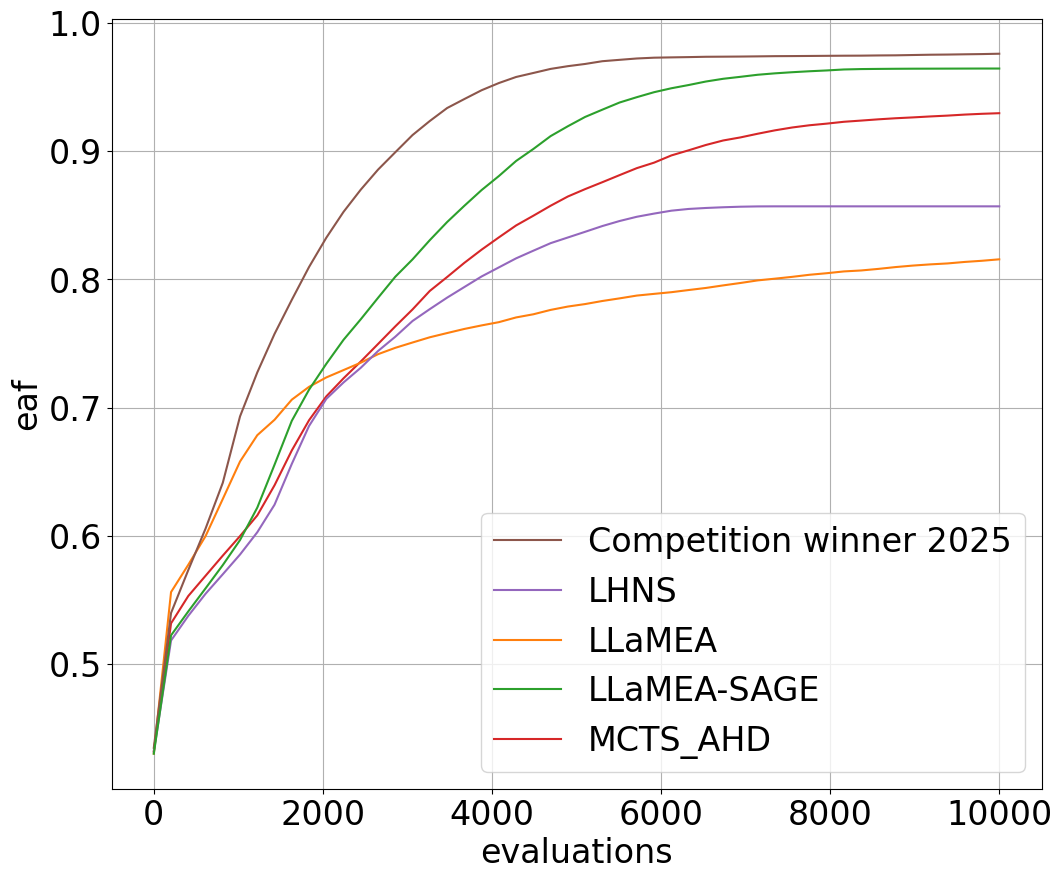

In [ ]:
import operator
custom_color_map = {
    "Competition winner 2025" :"C5",
    'MCTS_AHD': "C3", 
    'LHNS:vns': "C4",
    'ES': "C1",
    'ES-guided': "C2"
}

fig, ax = plt.subplots(1,1, figsize=(12,10))
_ = iohinspector.plot.plot_ecdf(df.filter(pl.col("dimension") == 5), y_max=100, y_min=1e-8, ax=ax, scale_xlog=False)
# Get the current legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Also get the lines (the actual plot objects) in the order they were created.
# Usually, ax.lines matches up with the unique hue levels in the same order
lines = ax.lines

# Make a mapping from label -> line object
label_to_line = dict(zip(labels, lines))

for handle, label in zip(handles, labels):
    # For bar charts, the handles are Rectangle patches
    handle.set_color(custom_color_map[label])
    handle.set_linestyle("-")

    if label == "ES":
        handle.set_label("LLaMEA")
    if label == "ES-guided":
        handle.set_label("LLaMEA-SAGE")
    if label == "LHNS:vns":
        handle.set_label("LHNS")

for label, line in label_to_line.items():
    # Set the color/linestyle on the actual plot line
    line.set_color(custom_color_map.get(label, 'black'))
    line.set_linestyle("-")
    

handles, labels = ax.get_legend_handles_labels()

# Sort them alphabetically (by label)
sorted_pairs = sorted(zip(labels, handles), key=operator.itemgetter(0))
sorted_labels, sorted_handles = zip(*sorted_pairs)

# Clear the old legend and create a new one in sorted order
ax.legend(sorted_handles, sorted_labels)
plt.show()

/home/neocortex/repos/BLADE/.venv/lib/python3.11/site-packages/iohinspector/align.py:109: UserWarning: Sortedness of columns cannot be checked when 'by' groups provided
  result_df = x_vals.join_asof(


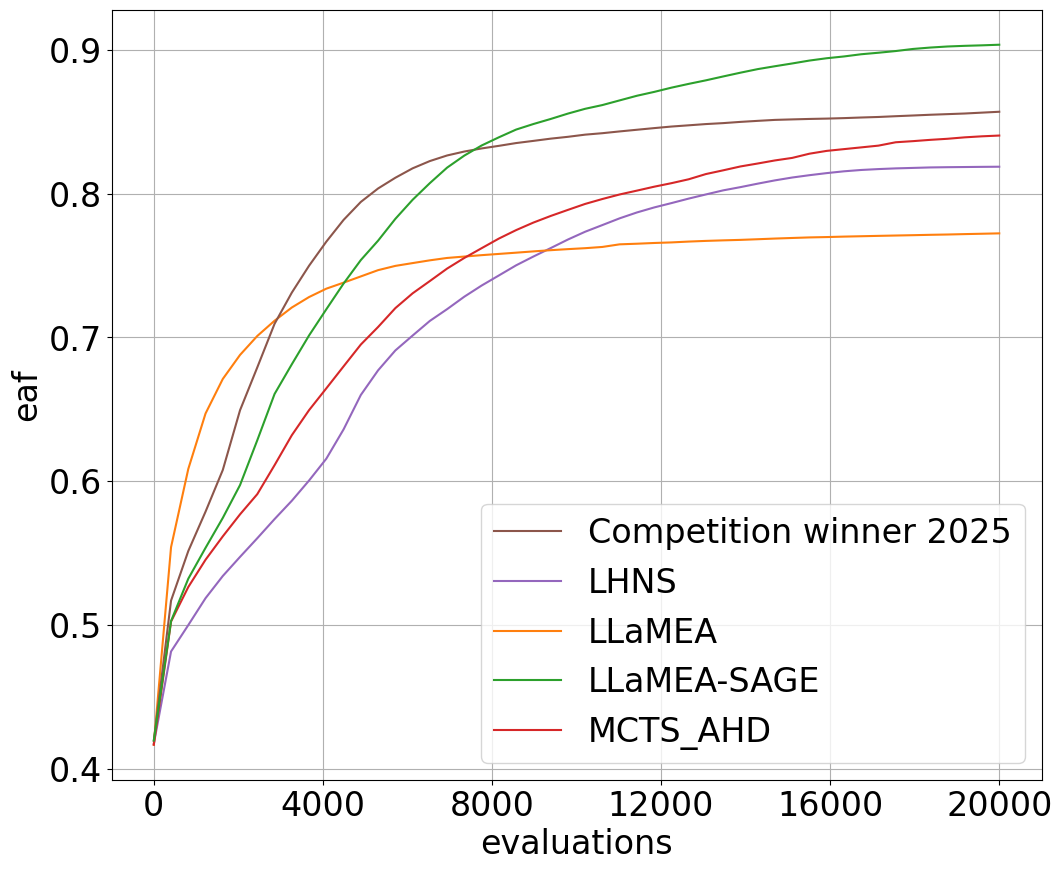

In [4]:
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
custom_color_map = {
    "Competition winner 2025" :"C5",
    'MCTS_AHD': "C3", 
    'LHNS:vns': "C4",
    'ES': "C1",
    'ES-guided': "C2"
}

fig, ax = plt.subplots(1,1, figsize=(12,10))
_ = iohinspector.plot.plot_ecdf(df.filter(pl.col("dimension") == 10), y_max=100, y_min=1e-8, ax=ax, scale_xlog=False)
# Get the current legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Also get the lines (the actual plot objects) in the order they were created.
# Usually, ax.lines matches up with the unique hue levels in the same order
lines = ax.lines

# Make a mapping from label -> line object
label_to_line = dict(zip(labels, lines))
for handle, label in zip(handles, labels):
    # For bar charts, the handles are Rectangle patches
    handle.set_color(custom_color_map[label])
    handle.set_linestyle("-")

    if label == "ES":
        handle.set_label("LLaMEA")
    if label == "ES-guided":
        handle.set_label("LLaMEA-SAGE")
    if label == "LHNS:vns":
        handle.set_label("LHNS")

for label, line in label_to_line.items():
    # Set the color/linestyle on the actual plot line
    line.set_color(custom_color_map.get(label, 'black'))
    line.set_linestyle("-")
    

handles, labels = ax.get_legend_handles_labels()

# Sort them alphabetically (by label)
sorted_pairs = sorted(zip(labels, handles), key=operator.itemgetter(0))
sorted_labels, sorted_handles = zip(*sorted_pairs)

# Clear the old legend and create a new one in sorted order
ax.legend(sorted_handles, sorted_labels)
from matplotlib.ticker import MaxNLocator

ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
plt.show()

/home/neocortex/repos/BLADE/.venv/lib/python3.11/site-packages/iohinspector/align.py:109: UserWarning: Sortedness of columns cannot be checked when 'by' groups provided
  result_df = x_vals.join_asof(


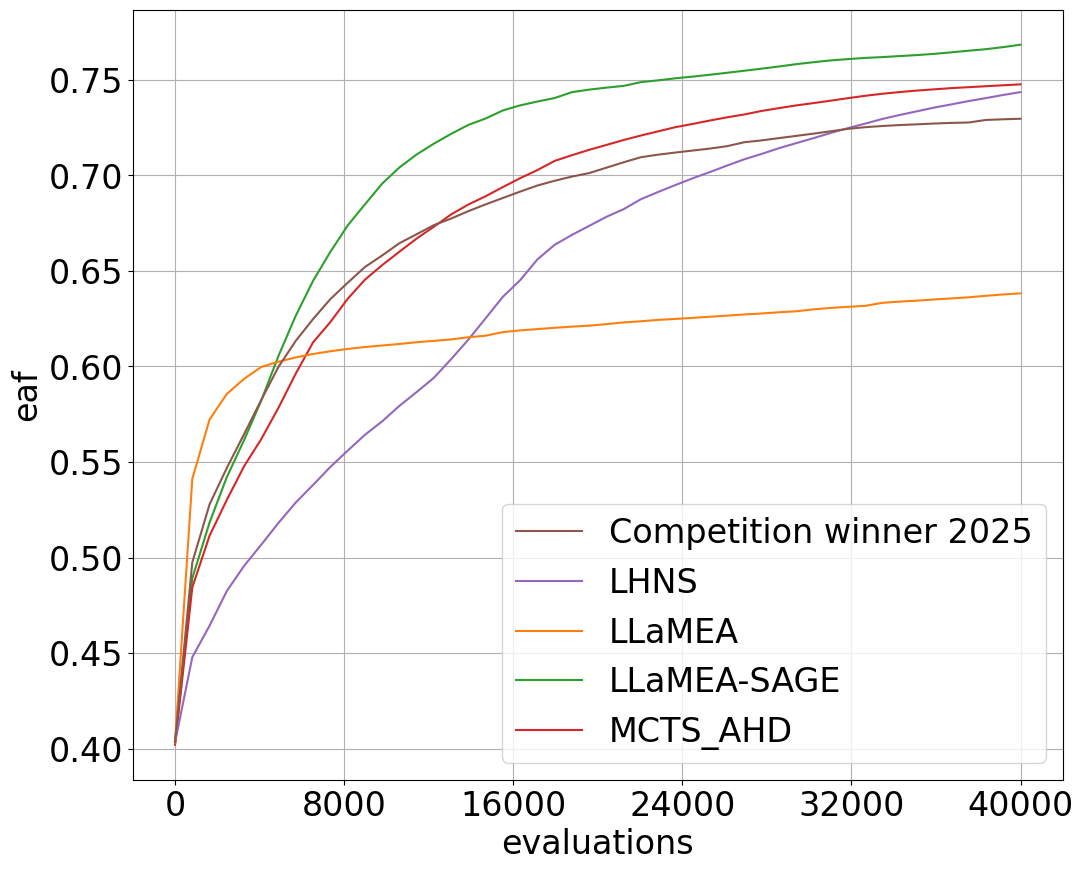

In [7]:
import operator


custom_color_map = {
    "Competition winner 2025" :"C5",
    'MCTS_AHD': "C3", 
    'LHNS:vns': "C4",
    'ES': "C1",
    'ES-guided': "C2"
}

fig, ax = plt.subplots(1,1, figsize=(12,10))
_ = iohinspector.plot.plot_ecdf(df.filter(pl.col("dimension") == 20), y_max=100, y_min=1e-8, ax=ax, scale_xlog=False)
# Get the current legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Also get the lines (the actual plot objects) in the order they were created.
# Usually, ax.lines matches up with the unique hue levels in the same order
lines = ax.lines

# Make a mapping from label -> line object
label_to_line = dict(zip(labels, lines))
for handle, label in zip(handles, labels):
    # For bar charts, the handles are Rectangle patches
    handle.set_color(custom_color_map[label])
    handle.set_linestyle("-")

    if label == "ES":
        handle.set_label("LLaMEA")
    if label == "ES-guided":
        handle.set_label("LLaMEA-SAGE")
    if label == "LHNS:vns":
        handle.set_label("LHNS")

for label, line in label_to_line.items():
    # Set the color/linestyle on the actual plot line
    line.set_color(custom_color_map.get(label, 'black'))
    line.set_linestyle("-")
    

handles, labels = ax.get_legend_handles_labels()

# Sort them alphabetically (by label)
sorted_pairs = sorted(zip(labels, handles), key=operator.itemgetter(0))
sorted_labels, sorted_handles = zip(*sorted_pairs)

# Clear the old legend and create a new one in sorted order
ax.legend(sorted_handles, sorted_labels)


ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
plt.show()

In [15]:
df_eaf = iohinspector.metrics.transform_fval(df, 1e-8, 1e2)
iohinspector.metrics.get_aocc(df_eaf.filter(pl.col("dimension") == 5), 10000, group_cols=['algorithm_name'])

algorithm_name,AOCC
str,f64
"""ES-guided""",0.761433
"""Competition winner 2025""",0.837403
"""MCTS_AHD""",0.703985
"""LHNS:vns""",0.647069
"""baseline CMA-ES""",0.743706
"""ES""",0.607933


In [16]:
df_eaf = iohinspector.metrics.transform_fval(df, 1e-8, 1e2)
iohinspector.metrics.get_aocc(df_eaf.filter(pl.col("dimension") == 10), 10000, group_cols=['algorithm_name'])

algorithm_name,AOCC
str,f64
"""Competition winner 2025""",0.593062
"""ES-guided""",0.5584
"""ES""",0.546282
"""MCTS_AHD""",0.479156
"""LHNS:vns""",0.431891
"""baseline CMA-ES""",0.650199


In [17]:
df_eaf = iohinspector.metrics.transform_fval(df, 1e-8, 1e2)
iohinspector.metrics.get_aocc(df_eaf.filter(pl.col("dimension") == 20), 10000, group_cols=['algorithm_name'])

algorithm_name,AOCC
str,f64
"""LHNS:vns""",0.222556
"""Competition winner 2025""",0.340909
"""MCTS_AHD""",0.31935
"""ES-guided""",0.357685
"""ES""",0.343585
"""baseline CMA-ES""",0.512196
